<a href="https://colab.research.google.com/github/Joao0298/-Challenge-Alura-Telecom-X_2/blob/main/TelecomX_parte2_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📡 Telecom X – Modelo de Previsão de Churn
Este notebook contém o modelo completo treinado com a base de dados fornecida, estendido com múltiplos modelos.

In [1]:
!pip install -q pandas numpy scikit-learn joblib matplotlib seaborn xgboost

## 1. Carregamento e Preparação dos Dados

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
import xgboost as xgb

def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

# Carregar dados
try:
    with open('TelecomX_Data.json', 'r') as f:
        data = json.load(f)
    df = pd.DataFrame([flatten_json(registro) for registro in data])
    print("Dados carregados com sucesso!")
except FileNotFoundError:
    print("Erro: Certifique-se de que o arquivo 'TelecomX_Data.json' está no mesmo diretório.")

# Renomear e Limpar
rename_map = {
    'customerID': 'customer_id', 'Churn': 'churn', 'customer_gender': 'gender',
    'customer_SeniorCitizen': 'senior_citizen', 'customer_Partner': 'partner',
    'customer_Dependents': 'dependents', 'customer_tenure': 'tenure',
    'phone_PhoneService': 'phone_service', 'phone_MultipleLines': 'multiple_lines',
    'internet_InternetService': 'internet_service', 'internet_OnlineSecurity': 'online_security',
    'internet_OnlineBackup': 'online_backup', 'internet_DeviceProtection': 'device_protection',
    'internet_TechSupport': 'tech_support', 'internet_StreamingTV': 'streaming_tv',
    'internet_StreamingMovies': 'streaming_movies', 'account_Contract': 'contract',
    'account_PaperlessBilling': 'paperless_billing', 'account_PaymentMethod': 'payment_method',
    'account_Charges_Monthly': 'monthly_charges', 'account_Charges_Total': 'total_charges'
}
df.rename(columns=rename_map, inplace=True)
df = df[df['churn'] != ''].copy()
df['churn'] = df['churn'].map({'Yes': 1, 'No': 0})
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce').fillna(0)

cols_to_fix = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
for col in cols_to_fix:
    df[col] = df[col].replace('No internet service', 'No')
df['multiple_lines'] = df['multiple_lines'].replace('No phone service', 'No')

df.head()

Dados carregados com sucesso!


,customer_id,churn,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges
0,0002-ORFBO,0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,1,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,1,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,1,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


## 2. Treinamento dos Modelos

In [3]:
X = df.drop(columns=['customer_id', 'churn'])
y = df['churn']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Pré-processador comum
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ])

# Modelo 1: Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Modelo 2: Regressão Logística
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Modelo 3: XGBoost (com ajuste para desbalanceamento)
scale_pos = sum(y == 0) / sum(y == 1)  # cálculo global, mas usaremos treino depois
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(scale_pos_weight=scale_pos, random_state=42, eval_metric='logloss'))
])

# Divisão treino-teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Treinamento
rf_pipeline.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)

# Para XGBoost, recalcular scale_pos_weight com base no treino
scale_pos_train = sum(y_train == 0) / sum(y_train == 1)
xgb_pipeline.set_params(classifier__scale_pos_weight=scale_pos_train)
xgb_pipeline.fit(X_train, y_train)

print("Modelos treinados!")

Modelos treinados!


## 3. Avaliação dos Modelos


Random Forest - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.65      0.47      0.55       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

AUC-ROC: 0.8215


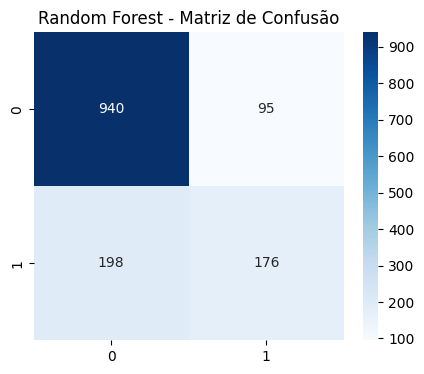

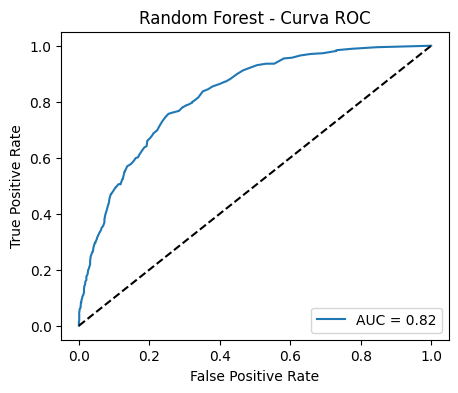


Logistic Regression - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

AUC-ROC: 0.8433


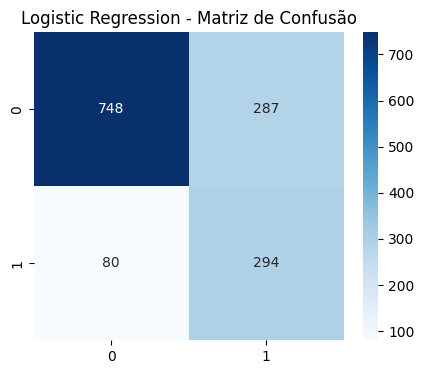

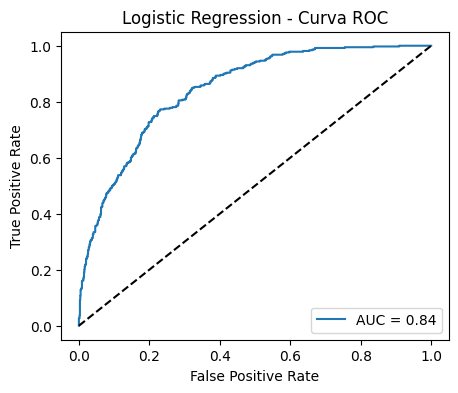


XGBoost - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1035
           1       0.54      0.68      0.60       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.71      1409
weighted avg       0.78      0.76      0.77      1409

AUC-ROC: 0.8170


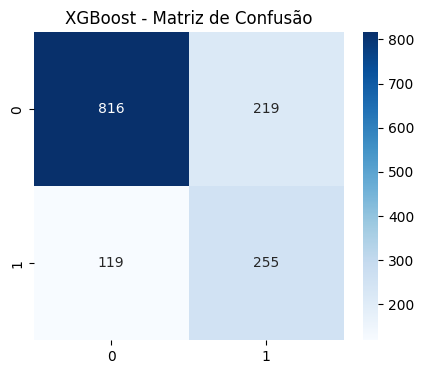

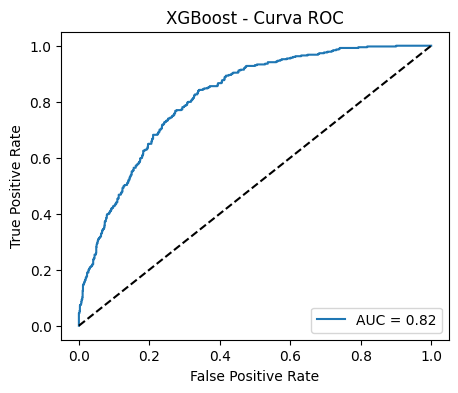


=== Comparação de Modelos ===
             Modelo  Accuracy  Precision (Churn)  Recall (Churn)  F1 (Churn)  AUC-ROC
Logistic Regression  0.739532           0.506024        0.786096    0.615707 0.843335
      Random Forest  0.792051           0.649446        0.470588    0.545736 0.821517
            XGBoost  0.760114           0.537975        0.681818    0.601415 0.817026


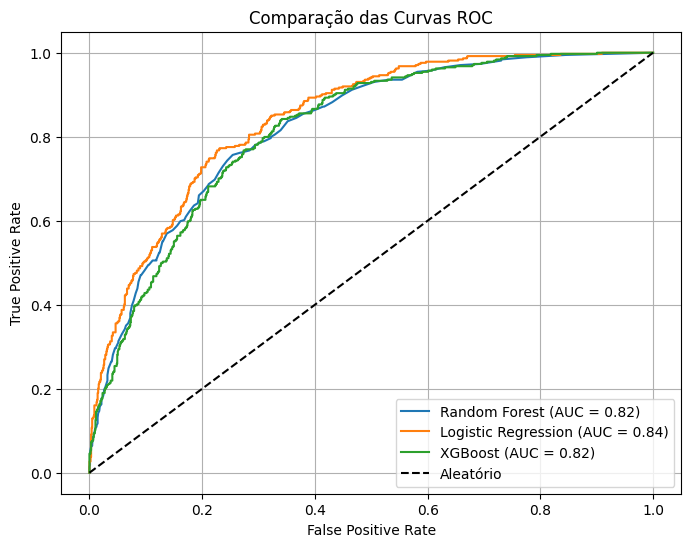

In [4]:
models = {
    'Random Forest': rf_pipeline,
    'Logistic Regression': lr_pipeline,
    'XGBoost': xgb_pipeline
}

metrics = []
roc_curves = {}  # armazenar curvas para comparação

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)

    metrics.append({
        'Modelo': name,
        'Accuracy': report['accuracy'],
        'Precision (Churn)': report['1']['precision'],
        'Recall (Churn)': report['1']['recall'],
        'F1 (Churn)': report['1']['f1-score'],
        'AUC-ROC': auc
    })

    print(f"\n{name} - Relatório de Classificação:")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {auc:.4f}")

    # Matriz de confusão
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Matriz de Confusão')
    plt.show()

    # Curva ROC individual
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_curves[name] = (fpr, tpr, auc)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

# Tabela comparativa
metrics_df = pd.DataFrame(metrics).sort_values('AUC-ROC', ascending=False)
print("\n=== Comparação de Modelos ===")
print(metrics_df.to_string(index=False))

# Gráfico comparativo das curvas ROC
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparação das Curvas ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 4. Importância das Variáveis


--- Random Forest ---
Importâncias (top 15):
total_charges                      0.180011
tenure                             0.166335
monthly_charges                    0.163771
contract_Two year                  0.059768
internet_service_Fiber optic       0.049076
payment_method_Electronic check    0.040755
contract_One year                  0.031249
paperless_billing_Yes              0.026105
gender_Male                        0.025594
internet_service_No                0.025538
tech_support_Yes                   0.024193
online_security_Yes                0.023869
partner_Yes                        0.022951
dependents_Yes                     0.020177
online_backup_Yes                  0.019134


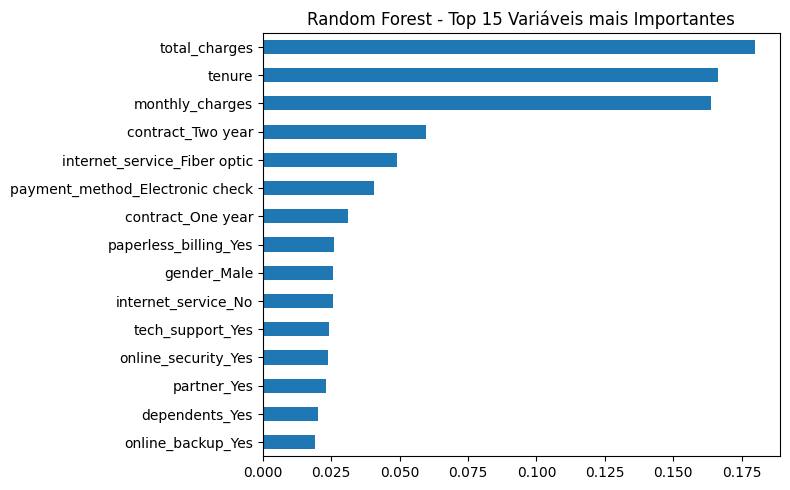


--- Logistic Regression ---
Coeficientes (top 15):
                               Feature      Coef
                         total_charges  0.619028
          internet_service_Fiber optic  0.563700
       payment_method_Electronic check  0.419867
                 paperless_billing_Yes  0.341421
                    multiple_lines_Yes  0.237547
                      streaming_tv_Yes  0.182714
                       monthly_charges  0.138952
                  streaming_movies_Yes  0.089483
                        senior_citizen  0.079961
payment_method_Credit card (automatic)  0.026672
           payment_method_Mailed check  0.002762
                           partner_Yes -0.054478
                           gender_Male -0.068370
                 device_protection_Yes -0.090410
                        dependents_Yes -0.163224


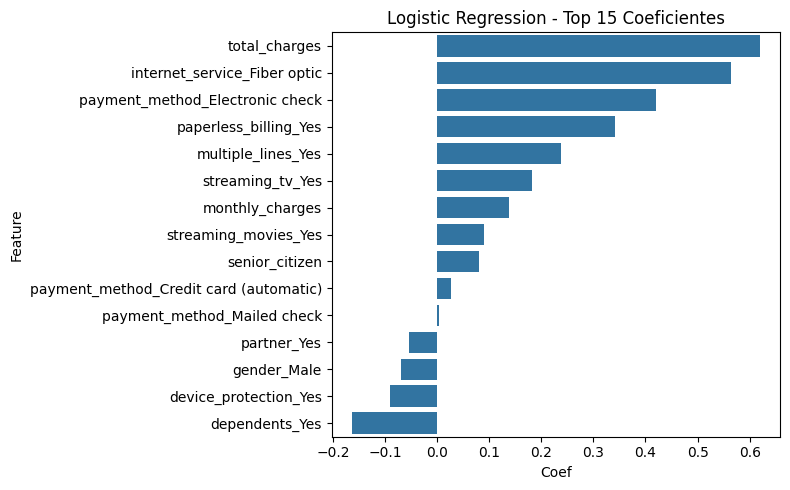


--- XGBoost ---
Importâncias (top 15):
contract_Two year                  0.373941
internet_service_Fiber optic       0.221785
contract_One year                  0.097427
internet_service_No                0.075931
streaming_movies_Yes               0.030765
tenure                             0.015801
phone_service_Yes                  0.015189
payment_method_Electronic check    0.015068
streaming_tv_Yes                   0.012491
senior_citizen                     0.011487
paperless_billing_Yes              0.011290
tech_support_Yes                   0.011256
multiple_lines_Yes                 0.011209
monthly_charges                    0.011150
total_charges                      0.010654


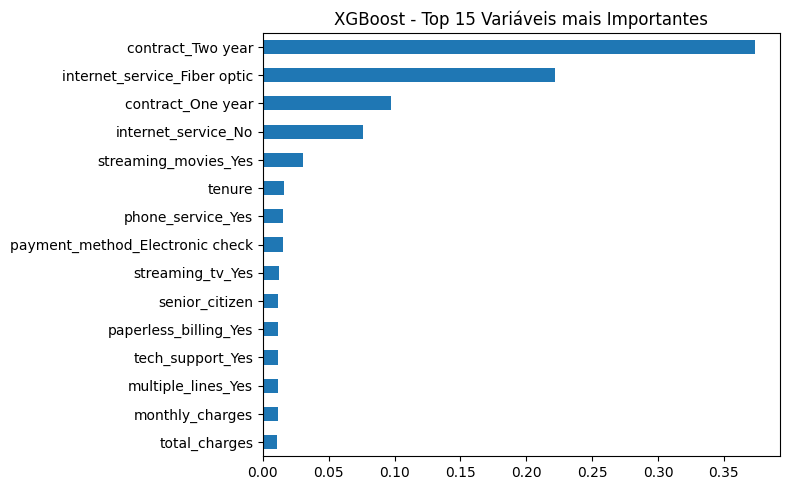

In [5]:
# Extrair nomes das features após o encoding
cat_features = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
all_features = num_cols + cat_features

for name, model in models.items():
    print(f"\n--- {name} ---")
    if name == 'Logistic Regression':
        coef = model.named_steps['classifier'].coef_[0]
        coef_df = pd.DataFrame({'Feature': all_features, 'Coef': coef}).sort_values('Coef', ascending=False)
        print("Coeficientes (top 15):")
        print(coef_df.head(15).to_string(index=False))
        plt.figure(figsize=(8,5))
        sns.barplot(x='Coef', y='Feature', data=coef_df.head(15))
        plt.title(f'{name} - Top 15 Coeficientes')
        plt.tight_layout()
        plt.show()
    else:
        importances = pd.Series(model.named_steps['classifier'].feature_importances_, index=all_features).sort_values(ascending=False)
        print("Importâncias (top 15):")
        print(importances.head(15).to_string())
        plt.figure(figsize=(8,5))
        importances.head(15).plot(kind='barh')
        plt.title(f'{name} - Top 15 Variáveis mais Importantes')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

## 5. Salvando o Melhor Modelo

In [6]:
# Escolher o melhor modelo com base na AUC-ROC no teste
best_name = max(models, key=lambda name: roc_auc_score(y_test, models[name].predict_proba(X_test)[:,1]))
best_model = models[best_name]
joblib.dump(best_model, 'modelo_churn_telecomx.pkl')
print(f"Modelo '{best_name}' salvo como 'modelo_churn_telecomx.pkl'")

Modelo 'Logistic Regression' salvo como 'modelo_churn_telecomx.pkl'
